## Implementing the collaborative filtering using deep learning
* Randomly Initialise Parameters — these will be the latent factors that help predict whether someone will like a movie.
* Calculate Predictions — this is done by taking the matrix dot product of the movie and user matrices. An example would be if a user’s likening to international films is high, and a movie is foreign; the product of the two will be large and, that movie will rank higher for that user.
* note: This approach could be used for prediction but is very inefficient as it requires a vector to be created and stored for each prediction.

In [1]:
#libreries
from fastai.collab import *
from fastai.tabular.all import *
from fastai import *
from fastai.metrics import *
from fastai.callback.tracker import *

#import acc from fastai.metrics
from fastai.metrics import accuracy, Precision, Recall
#from fastbook import *
import pandas as pd
import numpy as np
set_seed(42)

In [2]:
df = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/df_oversamling.csv')
df.head()

,userId,wine,rate
0,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Montepulciano 60,1
1,4e0cbfe3-8d73-4af4-b09e-f3193d1170a5,Zahorra Blanca,1
2,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1
3,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1
4,5ccd8030-047b-432c-a630-d784ab415756,Bardolino Chiaretto,1


In [3]:
# # #importing directly the confusion matrix
# # user_features_df = pd.read_csv('/home/bbruno/all_here/python course/thesis/knn/user_features_df.csv')
# # user_features_df

# #importing the user,movie,rating dataframe
# #we drop a column that was added by mistake by the system
# df = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote.csv')
# df.head()
# # df = pd.read_csv('/home/bbruno/all_here/python course/thesis/knn/df.csv').drop('Unnamed: 0', axis=1)
# # df.tail()

In [4]:
#we create a dataloader
#we pass the title of the movie and not the movie id
dls = CollabDataLoaders.from_df(df, user_name='userId',item_name='wine', bs=64)
#we can see the batch
dls.show_batch()

,userId,wine,rate
0,1818462e-a882-487f-9818-98faab99b3c4,Steak House Red,3
1,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,le vigne di zamo refosco,1
2,826c6abe-7147-4b69-aaea-275fe65b033a,Cavalcaonte Barbera Forlí,5
3,877019f9-3c77-491d-912e-58b2404aed47,Chianti,1
4,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Ribolla Gialla,5
5,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Friulano,1
6,7a20fe0e-38bf-4e66-967a-dd60aa05d77f,Russiz Superiore,5
7,91cf68cc-9436-43e1-871d-33beef4d2337,Legitimo Carinena,2
8,c2dfb861-cdad-4fb2-9460-fc794c7f6cad,Merlot (U),2
9,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Pistus,3


In [5]:
#CALCULATE PREDICTIONS USING MATRIX MULTIPLICATION

#we create a matrix with the user features
n_users = len(dls.classes['userId']) #the number of user is the lenght of how many users
#we create a matrix with the movie features
n_movies = len(dls.classes['wine']) #the number of movies is the lenght of how many movies
#we choose the number of factors
n_factors = 5 

#we create a random matrix with the user features(embeddings)
#userFactors = (numberOfUsers x 5)
user_factors = torch.randn(n_users, n_factors)
#we create a random matrix with the movie features(embeddings)
#movieFactors = (numberOfMovies x 5)
movie_factors = torch.randn(n_movies, n_factors)

##########################################
#To calculate the result for a particular movie and user combination, 
#we have to look up the index of the movie in our movie latent factor matrix and
#the index of the user in our user latent factor matrix; 
#then we can do our dot product between the two latent factor vectors

# Create a function that takes the user id and the movie title to make a prediction
def oneHotPredict(userId, title):
    '''In the oneHotPredict function, 
    we use the indices of the user and movie in the embedding matrices
    to look up the corresponding embeddings.
    ----
    We calculate the prediction by taking the dot product
    (element-wise multiplication and then sum) of the user and wine embeddings.
    '''
    userIdx = dls.classes['userId'].o2i[userId]
    movie_idx = dls.classes['wine'].o2i[title]
    
    user_embedding = user_factors[userIdx]
    movie_embedding = movie_factors[movie_idx]
    
    prediction = (user_embedding * movie_embedding).sum()
    return print(f"Predicted rating for user '{userId}' and '{title}': {prediction:.2f}")

In [6]:
# Prediction for user 9 and the movie 'Toy Story (1995)'
prediction = oneHotPredict('13016d41-00bd-411c-83f5-2b95691696b7', 'Pinot Grigio')
#print(f'Predicted rating for user 9 and Toy Story (1995): {prediction:.2f}')

Predicted rating for user '13016d41-00bd-411c-83f5-2b95691696b7' and 'Pinot Grigio': -0.66


## Matrix factorization
* A better approach

In [7]:
def create_params(size):
    """
      Pass tensor shape
      Returns normalised model parameters
    """
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

class DotProductBias(Module):
    """
    Model architecture for collaborative filtering
    """
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        """
        Initialises model with parameters
        :param n_users: number of users
        :param n_movies: number of movies
        :param n_factors: number of factors
        :param y_range: sigmoid limit
        """
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range

    def forward(self, x):
        """
        Applies a forward pass on the dataset passed
        :param x: data as DataLoaders obj
        :return: predictions in sigmoid range (tensor)
        """
        users = self.user_factors[x[:, 0]]
        movies = self.movie_factors[x[:, 1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:, 0]] + self.movie_bias[x[:, 1]]
        return sigmoid_range(res, *self.y_range)

In [8]:
#good model
#Working perfectly without cross validation
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat(),metrics=[mse, rmse, mae])
#wd = weight decay (L2 regularization)
learn.fit_one_cycle(10, 0.05, wd=0.1)
# # acc = 79.00%, train_loss = 0.134415, valid_loss = 0.236329, mse = 0.236329, rmse = 0.486136, mae = 0.268503

# #This model generalize good
# model = DotProductBias(n_users, n_movies, 50)
# learn = Learner(dls, model, loss_func=MSELossFlat(),metrics=[mse, rmse, mae])
# #wd = weight decay (L2 regularization)
# learn.fit_one_cycle(10, 0.003, wd=0.1)
# # acc = 68.24% , train_loss = 0.239520, valid_loss = 0.418527, mse = 0.418527, rmse = 0.646936, mae = 0.398856

epoch,train_loss,valid_loss,mse,_rmse,mae,time
0,1.846920,1.173903,1.173903,1.083468,0.882000,00:00
1,1.042485,0.440497,0.440497,0.663700,0.510971,00:00
2,0.732361,0.443789,0.443789,0.666175,0.483619,00:00
3,0.616177,0.396249,0.396249,0.629483,0.440758,00:00
4,0.539944,0.346189,0.346189,0.588379,0.408969,00:00
5,0.424438,0.307309,0.307309,0.554355,0.344692,00:00
6,0.334332,0.256875,0.256875,0.506828,0.308417,00:00
7,0.248912,0.242928,0.242928,0.492877,0.287374,00:00
8,0.180154,0.236984,0.236984,0.486810,0.270586,00:00
9,0.134415,0.236329,0.236329,0.486136,0.268503,00:00


SuggestedLRs(valley=0.013182567432522774)

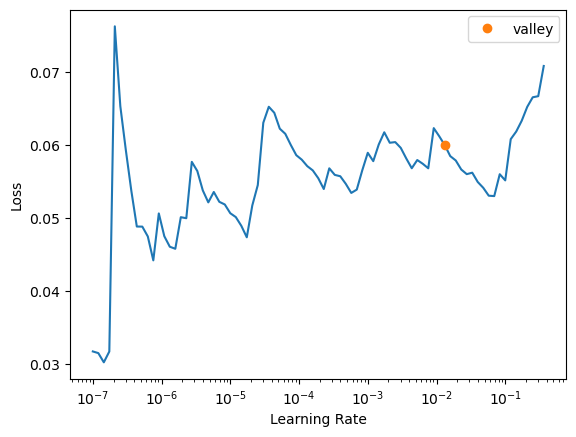

In [9]:
learn.lr_find()

In [10]:
#import torch.nn as nn
#Recommendations
def recommends(fav_movie, top_n=5):
    movie_factors = learn.model.movie_factors
    #we look up the movie in the movie factors
    idx = dls.classes['wine'].o2i[fav_movie]
    #find the movie with minimum distance
    distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
    #we sort the movies by distance
    idx = distances.argsort(descending=True)[1:top_n+1]
    #we return the movies
    recommended_movies = [dls.classes['wine'][i] for i in idx]
    return recommended_movies

recommended_movies = recommends('Pinot Grigio')
print("Recommended movies:")
for movie in recommended_movies:
    print(movie)

Recommended movies:
Pinot grigio
Chardonnay
Vistamar Cabernet Sauvignon Reserva
Chapel Peak - Fusional of Marlborough
Legitimo Carinena


In [11]:
#def prediction for a user
def prediction_user_like(userId, title):
    userIdx = dls.classes['userId'].o2i[userId]
    movie_idx = dls.classes['wine'].o2i[title]

    # Make a prediction using the model's forward method
    prediction = learn.model.forward(tensor([[userIdx, movie_idx]])).item()

    return print(f"Predicted rating for user '{userId}' and '{title}': {prediction:.2f}")

prediction = prediction_user_like('13016d41-00bd-411c-83f5-2b95691696b7', 'chardonnay')
prediction = prediction_user_like(50, 'cabernet sauvignon')

Predicted rating for user '13016d41-00bd-411c-83f5-2b95691696b7' and 'chardonnay': 3.18
Predicted rating for user '50' and 'cabernet sauvignon': 2.75


In [12]:
# Show 20 rows of results
learn.show_results(n=20)

,userId,wine,rate,rate_pred
0,61,296,3,2.995965
1,53,409,1,1.204577
2,99,671,1,1.006634
3,99,671,1,1.006634
4,21,376,5,4.955418
5,61,621,3,3.056275
6,110,439,5,4.945254
7,99,94,2,1.999293
8,168,584,2,1.994477


In [13]:
g = df.groupby('wine')['rate'].count()
top_wines = g.sort_values(ascending=False).index.values[:50]
top_wines[:10]

array(['Terrano', 'Friulano', 'Nerello mascalese', 'Chianti',
       "Moscato d'Asti", 'Campofiorin Rosso Veronese', '2/5 大亂鬥 2',
       'Rheinhessen Kabinett Riesling', '3／4 大亂鬥 11',
       'Morellino di Scansano 2021'], dtype=object)

In [14]:
from fastai.metrics import rmse

# Get predictions and targets
preds, targs = learn.get_preds()

# Calculate RMSE
error = rmse(preds, targs)
print(f'RMSE: {error}')

#MSE
error2 = mse(preds, targs)
print(f'MSE: {error2}')

#MAE
error3 = mae(preds, targs)
print(f'MAE: {error3}')

print(preds.shape)
print(targs.shape)

#transform the trags since they were a 2d tensor
targs = targs.squeeze()

#we create a dataframe with the predictions and the targets
df = pd.DataFrame({ 'targets': targs,'predictions': preds})
df.head(20)

#check the error
df['error'] = df['predictions'] - df['targets']


#print the error of the model
print(f"The error is : {df['error'].abs().mean()}")

df

RMSE: 0.48613640666007996
MSE: 0.2363286018371582
MAE: 0.26850295066833496
torch.Size([381])
torch.Size([381, 1])
The error is : 0.26850295066833496


,targets,predictions,error
0,1,0.991511,-0.008489
1,5,4.704081,-0.295919
2,2,1.986871,-0.013129
3,5,5.008782,0.008782
4,3,3.013859,0.013859
...,...,...,...
376,4,3.214201,-0.785799
377,4,3.249242,-0.750758
378,5,5.002077,0.002077
379,3,3.265886,0.265886


In [15]:
#sort by best predictions and worst predictions
#sort col error from 0 to 5(-5)

df['abs_error'] = df['error'].abs()
best_predictions = df.sort_values(by='abs_error', ascending=True)
worst_predictions = df.sort_values(by='error', ascending=False)

#best predictions
best_predictions.head(10)

,targets,predictions,error,abs_error
35,4,3.999994,-0.000006,0.000006
380,2,1.999892,-0.000108,0.000108
335,5,4.999671,-0.000329,0.000329
171,5,4.999671,-0.000329,0.000329
165,4,4.000376,0.000376,0.000376
87,2,1.999557,-0.000443,0.000443
79,2,1.999528,-0.000472,0.000472
137,2,1.999293,-0.000707,0.000707
296,2,2.001245,0.001245,0.001245
38,2,2.001245,0.001245,0.001245


In [16]:
worst_predictions.head(10)

,targets,predictions,error,abs_error
304,2,3.176036,1.176036,1.176036
314,2,3.176036,1.176036,1.176036
85,3,4.005115,1.005115,1.005115
18,3,3.984687,0.984687,0.984687
223,2,2.777828,0.777828,0.777828
50,2,2.777828,0.777828,0.777828
131,4,4.567863,0.567863,0.567863
111,3,3.539757,0.539757,0.539757
287,3,3.531168,0.531168,0.531168
289,3,3.525599,0.525599,0.525599


In [17]:
def get_accuracy(df):
    # Count correct predictions
    correct = 0
    for _, row in df.iterrows():
        if round(row['predictions']) == round(row['targets']):
            correct += 1

    # Compute accuracy
    accuracy_percentage = correct / len(df)
    return accuracy_percentage * 100

# Get accuracy
accuracy = get_accuracy(df)
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 79.00%


In [18]:
preds, targs = learn.get_preds()

# Now you can check their shapes
print(f'Predictions shape: {preds.shape}')
print(f'Targets shape: {targs.shape}')

Predictions shape: torch.Size([381])
Targets shape: torch.Size([381, 1])


In [19]:
# Remove the extra dimension from targets
targs = targs.squeeze()

# Now the shapes should match
print(f'Predictions shape: {preds.shape}')
print(f'Targets shape: {targs.shape}')

Predictions shape: torch.Size([381])
Targets shape: torch.Size([381])


In [20]:
# Assuming `dls` is your DataLoader
for i, batch in enumerate(dls.valid):
    x, y = batch
    print(f'Batch {i+1}: {x.shape[0]}')

# Check the shape of predictions and targets
print(f'Predictions: {preds.shape[0]}')
print(f'Targets: {targs.shape[0]}')

Batch 1: 64
Batch 2: 64
Batch 3: 64
Batch 4: 64
Batch 5: 64
Batch 6: 61
Predictions: 381
Targets: 381


In [21]:
print(f'Predictions: {preds.shape}')
print(f'Targets: {targs.shape}')

Predictions: torch.Size([381])
Targets: torch.Size([381])
